# Title: Lowest Housing Sale Price Among Similiar Boroughs

### Introduction/Business Problem

Singapore is a city-state with one of the most expensive housing market in the world.
About 80% of Singapore residents stay in public housing , managed by the Housing Development Board (HDB). In year 2018, the median sale price of HDB flat is S$408,000.
For someone looking to buy a new house in Singapore, this would mean careful research and planning is a must.

In this project, the objective to is help potential house owner make informed decision on the best Borough to purchase a HDB flat in, among other similar Boroughs.
Best borough in this case would be the lowest priced Borough among the other similiar Boroughs.

### Data

##### Definition:
1. Similiar Borough : Boroughs with simliar venues. As they have similiar amenities , this means the living conditions and lifestyles would be similar.
2. Lowest Housing Sale Price : Average price of all 2019 sale prices for each Borough


##### Data description:
1. Public housing flat resale price in 2019 from https://data.gov.sg/dataset/resale-flat-prices. 
2. This raw data to be clean and average sale price computed for each Borough
3. Use geopy library to get the latitude and longitude values of each Borough
4. Forsquare API to get the most common venues of each Borough



# CODE:

###### Download the dependencies

In [2]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import json
import re


import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


#import pylab as pl #for elbow curve 
import matplotlib.pyplot as plt #for elbow curve 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

###### Download Public housing flat resale price in 2019 from https://data.gov.sg/dataset/resale-flat-prices.

In [3]:
def download(url, user_agent='Mozilla/5.0', num_retries=2):
    print('Downloading:', url)
    headers = {'User-agent': user_agent}
    request = urllib2.Request(url, headers=headers)
    try:
        html = urllib2.urlopen(request).read()
    except urllib2.URLError as e:
        print('Download error:', e.reason)
        html = None
        if num_retries > 0:
            if hasattr(e, 'code') and 500 <= e.code < 600:
                # retry 5XX HTTP errors
                return download(url, user_agent, num_retries-1)
    return html


#url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=5&q=2019'

#api of data.gov.sg:- limit records to 50k
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&q=2019&limit=50000'


html = download(url)
type(html)

html_dict = json.loads(html.decode('utf-8'))

html_dict_records = html_dict['result']['records']
print('Number of records retrieved: ',len(html_dict_records))

#print(html_dict_records)

Downloading: https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&q=2019&limit=50000
Number of records retrieved:  10396


###### Tranform the data into a pandas dataframe

In [4]:
type(html_dict_records)
html_dict_records[0]

{'_full_count': '10396',
 '_id': 47482,
 'block': '624A',
 'flat_model': 'Model A',
 'flat_type': '4 ROOM',
 'floor_area_sqm': '95',
 'lease_commence_date': '2014',
 'month': '2019-04',
 'rank': 0.0573088,
 'remaining_lease': '94 years',
 'resale_price': '470000',
 'storey_range': '13 TO 15',
 'street_name': 'PUNGGOL CTRL',
 'town': 'PUNGGOL'}

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Street_Name', 'Resale_Price', 'Lease_Commence_Year', 'Floor_Area_Sqm', 'Flat_Type'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Street_Name,Resale_Price,Lease_Commence_Year,Floor_Area_Sqm,Flat_Type


In [7]:
#loop through the data and fill the dataframe one row at a time.
for data in html_dict_records:
    neighborhoods = neighborhoods.append({'Borough': data['town'],
                                          'Street_Name': data['street_name'],
                                          'Resale_Price': data['resale_price'],
                                          'Lease_Commence_Year': data['lease_commence_date'],
                                          'Floor_Area_Sqm': data['floor_area_sqm'],
                                          'Flat_Type': data['flat_type']
                                         }, ignore_index=True)
                                         
#remove duplicates
neighborhoods.drop_duplicates()

print('The dataframe has {} boroughs and {} records'.format(
        len(neighborhoods['Borough'].unique()), len(neighborhoods)
    )
)
neighborhoods.head()


The dataframe has 26 boroughs and 20792 records


,Borough,Street_Name,Resale_Price,Lease_Commence_Year,Floor_Area_Sqm,Flat_Type
0,PUNGGOL,PUNGGOL CTRL,470000,2014,95,4 ROOM
1,PUNGGOL,PUNGGOL WALK,590000,2015,113,5 ROOM
2,PUNGGOL,PUNGGOL WALK,555000,2015,113,5 ROOM
3,ANG MO KIO,ANG MO KIO AVE 1,270000,1981,68,3 ROOM
4,ANG MO KIO,ANG MO KIO AVE 1,295000,1976,73,3 ROOM


In [8]:
neighborhoods_pricedata = neighborhoods[['Borough','Resale_Price']].copy()

In [9]:
len(neighborhoods_pricedata)
neighborhoods_pricedata.head()

,Borough,Resale_Price
0,PUNGGOL,470000
1,PUNGGOL,590000
2,PUNGGOL,555000
3,ANG MO KIO,270000
4,ANG MO KIO,295000


In [10]:
#Change data type to Int
neighborhoods_pricedata['Resale_Price'] = neighborhoods_pricedata['Resale_Price'].astype("int")

In [11]:
#See data types
neighborhoods_pricedata.dtypes

Borough         object
Resale_Price     int64
dtype: object

In [12]:
neighborhoods_pricedata.head()

,Borough,Resale_Price
0,PUNGGOL,470000
1,PUNGGOL,590000
2,PUNGGOL,555000
3,ANG MO KIO,270000
4,ANG MO KIO,295000


In [13]:
#Average price for each Borough - include index
neighborhoods_avgprice_data = neighborhoods_pricedata.groupby(["Borough"]).mean().reset_index()

###### Use geopy library to get the latitude and longitude values of each Borough

In [14]:
neighborhoods_avgprice_data.head()

,Borough,Resale_Price
0,ANG MO KIO,382347.010776
1,BEDOK,399831.014572
2,BISHAN,617004.078818
3,BUKIT BATOK,380307.621053
4,BUKIT MERAH,561061.817967


In [15]:
#define geolocator function:

def get_location(address):
    
    geolocator = Nominatim(user_agent="tt_explorer")
    location = geolocator.geocode(address)
    latitude_sg = location.latitude
    longitude_sg = location.longitude
    #print(address, latitude_sg, longitude_sg)
    return latitude_sg, longitude_sg



In [16]:
nearby_names =[]
nearby_latitudes = []
nearby_longitudes = []
for i in neighborhoods_avgprice_data['Borough']:
    nearby_names.append(i)
    #add 'Singapore' to location name - make sure Singapore borough is retrieved
    sg_loc_name = i + ' Singapore'
    location_get = get_location(sg_loc_name)
    nearby_latitudes.append(location_get[0])
    nearby_longitudes.append(location_get[1])

In [17]:
print(len(nearby_names), len(nearby_latitudes), len(nearby_longitudes))

26 26 26


###### Define Foursquare Credentials and Version

In [18]:
# The code was removed by Watson Studio for sharing.

###### Create a function to repeat the same process to all the neighborhoods in Singapore

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

###### Write the code to run the above function on each neighborhood and create a new dataframe called sg_venues.

In [20]:
LIMIT = 100 #limit of number of venues returned by Foursquare API

import requests # library to handle requests

sg_venues = getNearbyVenues(nearby_names, nearby_latitudes, nearby_longitudes)

ANG MO KIO
BEDOK
BISHAN
BUKIT BATOK
BUKIT MERAH
BUKIT PANJANG
BUKIT TIMAH
CENTRAL AREA
CHOA CHU KANG
CLEMENTI
GEYLANG
HOUGANG
JURONG EAST
JURONG WEST
KALLANG/WHAMPOA
MARINE PARADE
PASIR RIS
PUNGGOL
QUEENSTOWN
SEMBAWANG
SENGKANG
SERANGOON
TAMPINES
TOA PAYOH
WOODLANDS
YISHUN


In [21]:
#Check the size of the resulting dataframe
print(sg_venues.shape)
sg_venues.head()

(964, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ANG MO KIO,1.369842,103.846609,Old Chang Kee,1.369094,103.848389,Snack Place
1,ANG MO KIO,1.369842,103.846609,Subway,1.369136,103.847612,Sandwich Place
2,ANG MO KIO,1.369842,103.846609,Bun Master,1.369242,103.849031,Bakery
3,ANG MO KIO,1.369842,103.846609,MOS Burger,1.369170,103.847831,Burger Joint
4,ANG MO KIO,1.369842,103.846609,PLAYe,1.369109,103.848225,Hobby Shop


In [22]:
#Check how many venues were returned for each neighborhood
sg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ANG MO KIO,48,48,48,48,48,48
BEDOK,57,57,57,57,57,57
BISHAN,39,39,39,39,39,39
BUKIT BATOK,24,24,24,24,24,24
BUKIT MERAH,33,33,33,33,33,33
BUKIT PANJANG,8,8,8,8,8,8
BUKIT TIMAH,12,12,12,12,12,12
CENTRAL AREA,85,85,85,85,85,85
CHOA CHU KANG,12,12,12,12,12,12


In [23]:
#Find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 160 uniques categories.


###### Analyze Each Neighborhood

In [24]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Optical Shop,Outdoor Sculpture,Paella Restaurant,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soccer Field,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taxi Stand,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Waterfront,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
#Examine the new dataframe size.
sg_onehot.shape

(964, 160)

###### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [26]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Sculpture,Paella Restaurant,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soccer Field,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taxi Stand,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Waterfront,Wings Joint
0,ANG MO KIO,0.000000,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.062500,0.0,0.020833,0.0,0.000000,0.0,0.000000,0.0,0.020833,0.0,0.0,0.0,0.020833,0.000000,0.0,0.0,0.125000,0.0,0.0,0.020833,0.000000,0.000000,0.0,0.000000,0.041667,0.0,0.0,0.000000,0.020833,0.0,0.041667,0.000000,0.000000,0.0,0.062500,0.0,0.0,0.000000,0.000000,0.020833,0.0,0.0,0.0,0.0,0.000000,0.020833,0.020833,0.000000,0.020833,0.0,0.0,0.020833,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.041667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020833,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.020833,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020833,0.0,0.0,0.0,0.000000,0.0,0.0,0.041667,0.0,0.0,0.020833,0.0,0.020833,0.0,0.0,0.041667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.041667,0.041667,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.020833,0.0,0.0,0.0,0.000000
1,BEDOK,0.000000,0.0,0.017544,0.0,0.0,0.0,0.052632,0.0,0.0,0.017544,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.000000,0.000000,0.017544,0.0,0.017544,0.0,0.017544,0.0,0.017544,0.0,0.000000,0.0,0.035088,0.0,0.0,0.0,0.035088,0.017544,0.0,0.0,0.070175,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.0,0.0,0.017544,0.000000,0.0,0.035088,0.000000,0.000000,0.0,0.052632,0.0,0.0,0.017544,0.017544,0.017544,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.017544,0.0,0.0,0.0,0.017544,0.017544,0.017544,0.017544,0.017544,0.0,0.052632,0.0,0.017544,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01

In [27]:
#Confirm the new size
sg_grouped.shape

(26, 160)

# Explore the neighborhoods in Singapore

In [28]:
num_top_venues = 5

for hood in sg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANG MO KIO----
                  venue  freq
0           Coffee Shop  0.12
1            Food Court  0.06
2       Bubble Tea Shop  0.06
3      Sushi Restaurant  0.04
4  Fast Food Restaurant  0.04


----BEDOK----
                 venue  freq
0          Coffee Shop  0.07
1     Asian Restaurant  0.05
2  Japanese Restaurant  0.05
3       Sandwich Place  0.05
4           Food Court  0.05


----BISHAN----
             venue  freq
0      Coffee Shop  0.10
1       Food Court  0.08
2  Bubble Tea Shop  0.08
3   Ice Cream Shop  0.05
4             Café  0.05


----BUKIT BATOK----
                  venue  freq
0           Coffee Shop  0.17
1            Food Court  0.08
2  Fast Food Restaurant  0.08
3    Chinese Restaurant  0.08
4    Frozen Yogurt Shop  0.04


----BUKIT MERAH----
                venue  freq
0                Café  0.12
1    Asian Restaurant  0.12
2  Chinese Restaurant  0.09
3           Bookstore  0.06
4          Food Court  0.06


----BUKIT PANJANG----
                venue  freq


###### Put into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Coffee Shop,Bubble Tea Shop,Food Court,Sushi Restaurant,Fast Food Restaurant,Snack Place,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Sandwich Place,Japanese Restaurant,Café,Sushi Restaurant,Fast Food Restaurant,Supermarket,Chinese Restaurant
2,BISHAN,Coffee Shop,Food Court,Bubble Tea Shop,Supermarket,Chinese Restaurant,Café,Japanese Restaurant,Ice Cream Shop,Cosmetics Shop,Pet Store
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Sandwich Place,Toy / Game Store,Asian Restaurant,Bus Station
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Coffee Shop,Noodle House,Bookstore,Food Court,Flea Market,Japanese Restaurant,Hainan Restaurant


# Cluster the neighborhoods in Singapore

In [31]:
#get dataset ready for clustering
sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

Use Elbow Curve to determine nummber of clusters

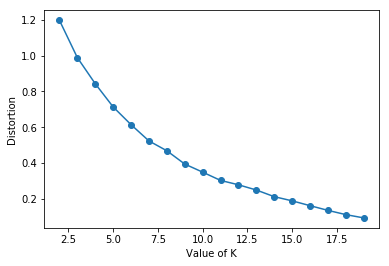

In [34]:
Ks = range(2, 20) 
Ds = []
for K in Ks: 
    cls = KMeans(n_clusters=K, random_state=101) 
    cls.fit(sg_grouped_clustering) 
    Ds.append(cls.inertia_) 
plt.plot(Ks, Ds, 'o-') 
plt.xlabel("Value of K") 
plt.ylabel("Distortion") 
plt.show()

From Elbow Curve above, the distortion decreases slowly from K = 8 onwards.
Run k-means to cluster the neighborhood into 8 clusters

In [35]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 0, 2, 1, 3, 2, 0, 2], dtype=int32)

In [36]:
labels = kmeans.labels_

In [37]:
#We assign the labels to each row in dataframe.
neighborhoods_venues_sorted['Cluster_Number'] = labels
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number
0,ANG MO KIO,Coffee Shop,Bubble Tea Shop,Food Court,Sushi Restaurant,Fast Food Restaurant,Snack Place,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,2
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Sandwich Place,Japanese Restaurant,Café,Sushi Restaurant,Fast Food Restaurant,Supermarket,Chinese Restaurant,2
2,BISHAN,Coffee Shop,Food Court,Bubble Tea Shop,Supermarket,Chinese Restaurant,Café,Japanese Restaurant,Ice Cream Shop,Cosmetics Shop,Pet Store,2
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Sandwich Place,Toy / Game Store,Asian Restaurant,Bus Station,0
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Coffee Shop,Noodle House,Bookstore,Food Court,Flea Market,Japanese Restaurant,Hainan Restaurant,2


In [38]:
#Rename column Borough to Neighorhood , before joining
neighborhoods_price = neighborhoods_avgprice_data.rename(columns={"Borough":"Neighborhood"})

In [39]:
neighborhoods_price.head()

,Neighborhood,Resale_Price
0,ANG MO KIO,382347.010776
1,BEDOK,399831.014572
2,BISHAN,617004.078818
3,BUKIT BATOK,380307.621053
4,BUKIT MERAH,561061.817967


In [40]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number
0,ANG MO KIO,Coffee Shop,Bubble Tea Shop,Food Court,Sushi Restaurant,Fast Food Restaurant,Snack Place,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,2
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Sandwich Place,Japanese Restaurant,Café,Sushi Restaurant,Fast Food Restaurant,Supermarket,Chinese Restaurant,2
2,BISHAN,Coffee Shop,Food Court,Bubble Tea Shop,Supermarket,Chinese Restaurant,Café,Japanese Restaurant,Ice Cream Shop,Cosmetics Shop,Pet Store,2
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Sandwich Place,Toy / Game Store,Asian Restaurant,Bus Station,0
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Coffee Shop,Noodle House,Bookstore,Food Court,Flea Market,Japanese Restaurant,Hainan Restaurant,2


In [41]:
#Merge both dataframe together to get both Cluster number and Average Resale Price
combined_data = neighborhoods_venues_sorted.merge(neighborhoods_price, on='Neighborhood', how='left')

In [42]:
combined_data.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number,Resale_Price
0,ANG MO KIO,Coffee Shop,Bubble Tea Shop,Food Court,Sushi Restaurant,Fast Food Restaurant,Snack Place,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,2,382347.010776
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Sandwich Place,Japanese Restaurant,Café,Sushi Restaurant,Fast Food Restaurant,Supermarket,Chinese Restaurant,2,399831.014572
2,BISHAN,Coffee Shop,Food Court,Bubble Tea Shop,Supermarket,Chinese Restaurant,Café,Japanese Restaurant,Ice Cream Shop,Cosmetics Shop,Pet Store,2,617004.078818
3,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Sandwich Place,Toy / Game Store,Asian Restaurant,Bus Station,0,380307.621053
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Coffee Shop,Noodle House,Bookstore,Food Court,Flea Market,Japanese Restaurant,Hainan Restaurant,2,561061.817967


In [43]:
combined_data_sorted = combined_data.sort_values(['Cluster_Number', 'Resale_Price'], ascending=True)

# Visualize the resulting clusters

In [44]:
#Get Singapore location
sin_latitude, sin_longitude=get_location('Singapore')


In [45]:
#Create dataframe with neighbour latitude and longitude
sin_neighborhood_location = sg_venues[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude']].copy().drop_duplicates()

In [46]:
sin_neighborhood_location.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,ANG MO KIO,1.369842,103.846609
48,BEDOK,1.323976,103.930216
105,BISHAN,1.351452,103.848250
144,BUKIT BATOK,1.349057,103.749591
168,BUKIT MERAH,1.280628,103.830591


In [47]:
#Merge both dataframe together to get both Cluster number and Average Resale Price
combined_data_location = combined_data_sorted.merge(sin_neighborhood_location, on='Neighborhood', how='left')

In [48]:
combined_data_location.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number,Resale_Price,Neighborhood Latitude,Neighborhood Longitude
0,SEMBAWANG,Coffee Shop,Asian Restaurant,Wings Joint,Chinese Restaurant,Bus Station,Bistro,Fast Food Restaurant,Café,Supermarket,Shopping Mall,0,365279.450980,1.448065,103.820760
1,CHOA CHU KANG,Fast Food Restaurant,Playground,Asian Restaurant,Coffee Shop,Shoe Store,Sandwich Place,Thai Restaurant,Food Court,Cosmetics Shop,Park,0,378231.267123,1.389260,103.743728
2,BUKIT BATOK,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Sandwich Place,Toy / Game Store,Asian Restaurant,Bus Station,0,380307.621053,1.349057,103.749591
3,BUKIT PANJANG,Food Court,Park,Market,Noodle House,Miscellaneous Shop,Salon / Barbershop,Electronics Store,Food & Drink Shop,Food,Flea Market,1,429277.918854,1.377921,103.771866
4,WOODLANDS,Japanese Restaurant,Chinese Restaurant,Café,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Clothing Store,Basketball Court,Shopping Mall,Electronics Store,2,367538.507446,1.436897,103.786216


Create and display Singapore map with clusters

In [49]:
# create map
map_clusters = folium.Map(location=[sin_latitude, sin_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(combined_data_location['Neighborhood Latitude'], combined_data_location['Neighborhood Longitude'], combined_data_location['Neighborhood'], combined_data_location['Cluster_Number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Display Lowest Housing Sale Price Among Similiar Boroughs

###### Lowest Housing Sale Price Borough in Cluster 1

In [50]:
#Cluster 1
cluster1 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 0, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster1.iloc[0]

Neighborhood                         SEMBAWANG
1st Most Common Venue              Coffee Shop
2nd Most Common Venue         Asian Restaurant
3rd Most Common Venue              Wings Joint
4th Most Common Venue       Chinese Restaurant
5th Most Common Venue              Bus Station
6th Most Common Venue                   Bistro
7th Most Common Venue     Fast Food Restaurant
8th Most Common Venue                     Café
9th Most Common Venue              Supermarket
10th Most Common Venue           Shopping Mall
Cluster_Number                               0
Resale_Price                            365279
Neighborhood Latitude                  1.44806
Neighborhood Longitude                 103.821
Name: 0, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 2

In [51]:
#Cluster 2
cluster2 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 1, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster2.iloc[0]

Neighborhood                   BUKIT PANJANG
1st Most Common Venue             Food Court
2nd Most Common Venue                   Park
3rd Most Common Venue                 Market
4th Most Common Venue           Noodle House
5th Most Common Venue     Miscellaneous Shop
6th Most Common Venue     Salon / Barbershop
7th Most Common Venue      Electronics Store
8th Most Common Venue      Food & Drink Shop
9th Most Common Venue                   Food
10th Most Common Venue           Flea Market
Cluster_Number                             1
Resale_Price                          429278
Neighborhood Latitude                1.37792
Neighborhood Longitude               103.772
Name: 3, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 3

In [52]:
#Cluster 3
cluster3 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 2, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster3.iloc[0]

Neighborhood                         WOODLANDS
1st Most Common Venue      Japanese Restaurant
2nd Most Common Venue       Chinese Restaurant
3rd Most Common Venue                     Café
4th Most Common Venue              Coffee Shop
5th Most Common Venue         Asian Restaurant
6th Most Common Venue     Fast Food Restaurant
7th Most Common Venue           Clothing Store
8th Most Common Venue         Basketball Court
9th Most Common Venue            Shopping Mall
10th Most Common Venue       Electronics Store
Cluster_Number                               2
Resale_Price                            367539
Neighborhood Latitude                   1.4369
Neighborhood Longitude                 103.786
Name: 4, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 4

In [53]:
#Cluster 4
cluster4 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 3, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster4.iloc[0]

Neighborhood                       BUKIT TIMAH
1st Most Common Venue                    Trail
2nd Most Common Venue                Rest Area
3rd Most Common Venue                 Mountain
4th Most Common Venue           Scenic Lookout
5th Most Common Venue       Dim Sum Restaurant
6th Most Common Venue              Flea Market
7th Most Common Venue     Fast Food Restaurant
8th Most Common Venue              Event Space
9th Most Common Venue        Electronics Store
10th Most Common Venue     Dumpling Restaurant
Cluster_Number                               3
Resale_Price                            713304
Neighborhood Latitude                  1.35469
Neighborhood Longitude                 103.776
Name: 20, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 5

In [54]:
#Cluster 5
cluster5 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 4, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster5.iloc[0]

Neighborhood                           PUNGGOL
1st Most Common Venue               Food Court
2nd Most Common Venue            Movie Theater
3rd Most Common Venue       Chinese Restaurant
4th Most Common Venue              High School
5th Most Common Venue              Bus Station
6th Most Common Venue        Electronics Store
7th Most Common Venue        Food & Drink Shop
8th Most Common Venue                     Food
9th Most Common Venue              Flea Market
10th Most Common Venue    Fast Food Restaurant
Cluster_Number                               4
Resale_Price                            463184
Neighborhood Latitude                  1.39803
Neighborhood Longitude                 103.907
Name: 21, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 6

In [55]:
#Cluster 6
cluster6 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 5, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster6.iloc[0]

Neighborhood                   KALLANG/WHAMPOA
1st Most Common Venue       Chinese Restaurant
2nd Most Common Venue              Coffee Shop
3rd Most Common Venue                Pet Store
4th Most Common Venue               Restaurant
5th Most Common Venue               Food Court
6th Most Common Venue               Hotel Pool
7th Most Common Venue                Juice Bar
8th Most Common Venue             Dance Studio
9th Most Common Venue     Gym / Fitness Center
10th Most Common Venue                Bus Line
Cluster_Number                               5
Resale_Price                            494525
Neighborhood Latitude                  1.32511
Neighborhood Longitude                 103.867
Name: 22, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 7

In [56]:
#Cluster 7
cluster7 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 6, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster7.iloc[0]

Neighborhood                         SERANGOON
1st Most Common Venue               Playground
2nd Most Common Venue                     Café
3rd Most Common Venue                Pet Store
4th Most Common Venue                 Bus Line
5th Most Common Venue              Bus Station
6th Most Common Venue         Basketball Court
7th Most Common Venue        Electronics Store
8th Most Common Venue                     Food
9th Most Common Venue              Flea Market
10th Most Common Venue    Fast Food Restaurant
Cluster_Number                               6
Resale_Price                            480534
Neighborhood Latitude                  1.36324
Neighborhood Longitude                 103.874
Name: 23, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 8

In [57]:
#Cluster 8
cluster8 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 7, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster8.iloc[0]

Neighborhood                                    GEYLANG
1st Most Common Venue                Chinese Restaurant
2nd Most Common Venue                        Food Court
3rd Most Common Venue                      Noodle House
4th Most Common Venue     Vegetarian / Vegan Restaurant
5th Most Common Venue                Dim Sum Restaurant
6th Most Common Venue                  Asian Restaurant
7th Most Common Venue                     Grocery Store
8th Most Common Venue                      Dessert Shop
9th Most Common Venue                     Train Station
10th Most Common Venue               Seafood Restaurant
Cluster_Number                                        7
Resale_Price                                     429117
Neighborhood Latitude                           1.31819
Neighborhood Longitude                          103.887
Name: 24, dtype: object